# Наша первая свёрточная нейросеть 

Пришло время построить нашу первую свёрточную нейросеть. Будем использовать для этого датасет [fashion MNIST.](https://www.cs.toronto.edu/~kriz/cifar.html) Набор данных включает в себя изображения рукописных цифр.  

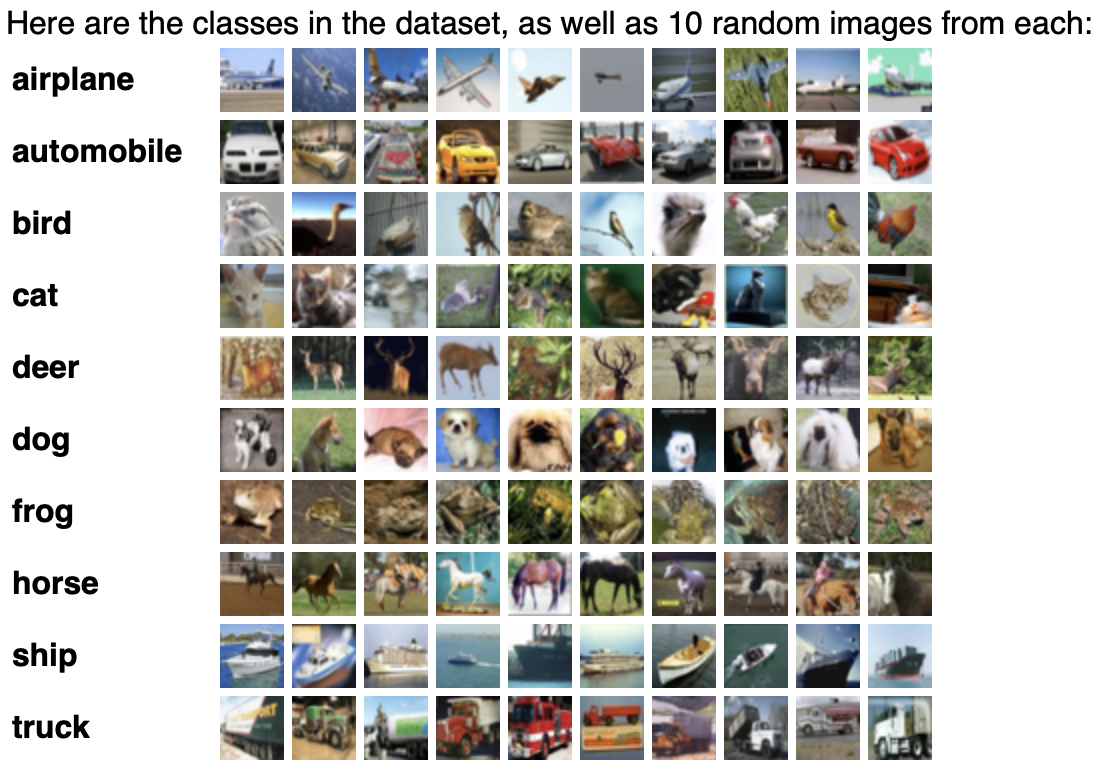

In [2]:
from IPython import display
display.Image('images/Fashion.png', retina=True)

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.__version__

'1.6.0+cu101'

In [4]:
import numpy as np
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Смотрим на данные 

Скачаеми приготовим данные. Буквально через минуту в наших руках окажутся $60 000$ картинок размера $28 \times 28$.

In [5]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                             download=True, 
                                             transform=transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                            download=True, 
                                            transform=transforms.ToTensor())

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


KeyboardInterrupt: 

In [ ]:
trainset[0][0]*255

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Нарисуем несколько рандомных картинок из тренировочной выборки. 

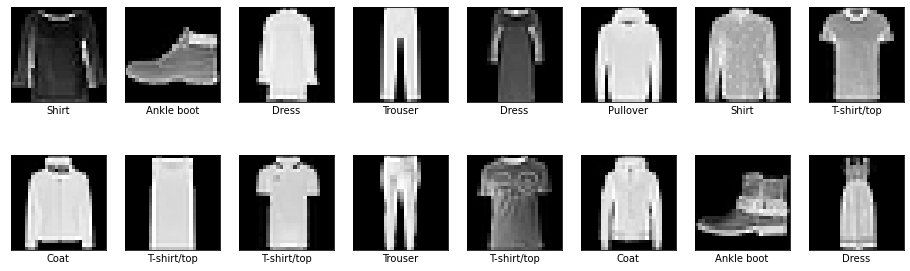

In [ ]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(trainset))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(trainset[random_index][0].squeeze(), cmap = 'gray')
        ax.set_xlabel(class_names[trainset[random_index][1]])
plt.show()

## 2.  Выбираем для нашей нейросети архитектуру

Свёрточная нейронная сеть строится из нескольких разных типов слоёв: 

* [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) - Конволюция
* [MaxPooling2D](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool2d.html?highlight=maxpool#torch.nn.AdaptiveMaxPool2d) - макспулинг
* [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten) - разворачивает картинку в вектор 
* [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn%20linear#torch.nn.Linear) - полносвязный слой (fully-connected layer)
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=nn%20relu#torch.nn.ReLU) - функция активации
* [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html?highlight=leaky#torch.nn.LeakyReLU) - leaky relu активация
* [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=nn%20dropout#torch.nn.Dropout) - дропаут.


В модели, которую мы определим ниже, на вход будет идти тензоры размера __(None, 28, 28, 1)__ и __(None, 10)__. На выходе мы будем получать вероятноть того, что объект относится к конкретному классу. Разменость __None__ заготовлена для размерности батча. 

## 2.1 Полносвязная сетка 

Соберём полносвязную сетку с нашей предыдущей пары

**Важный момент:** после последнего FC слоя `softmax` не вызывается, т.к. он заложен внутрь [`nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [ ]:
RANDOM_SEED = 1234
torch.manual_seed(RANDOM_SEED)

In [ ]:
class FC(nn.Module):
    def __init__(self): 
        super().__init__()
        self.classifier = nn.Sequential(nn.Linear(784, 64),  # 28 x 28 = 784
                                        nn.BatchNorm1d(64),
                                        nn.ReLU(),
                                        nn.Linear(64, 32),
                                        nn.BatchNorm1d(32),
                                        nn.ReLU(),
                                        nn.Linear(32, 16),
                                        nn.BatchNorm1d(16),
                                        nn.ReLU(),
                                        nn.Linear(16, 10),
                                    )
             
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        logits = self.classifier(x)
        # probs = F.softmax(logits, dim=1) # if no dim is given, then a warning will appear
        return logits

In [ ]:
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
iter(trainloader).next()[0].shape

torch.Size([512, 1, 28, 28])

In [ ]:
device = 'cpu'  # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model_fc = FC()
model_fc.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model_fc.parameters(), lr=0.01)

cpu


In [ ]:
def train_nn(trainloader, model, opt, loss_fn, device):
    running_loss = []

    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)

        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs.cpu(), labels)
        loss.backward()
        opt.step()
        
        running_loss.append(loss.item())

    return model, running_loss


def eval_nn(testloader, model, loss_fn, device):
    running_loss_test = []

    model.eval()
    predicts = np.array([])
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)

        outputs = model(inputs)
        predicts = np.append(predicts, outputs.cpu().argmax(dim=1).numpy())
        loss = loss_fn(outputs.cpu(), labels)

        running_loss_test.append(loss.item())
    return running_loss_test, predicts.astype(int)

In [ ]:
def training_loop(model, trainloader, testloader, opt, loss_fn, device, max_epochs=20):
    loss_arr = []
    loss_arr_test = []

    for epoch in range(max_epochs):        
        model, running_loss = train_nn(trainloader, model, opt, loss_fn, device)
        running_loss_test, _ = eval_nn(testloader, model, loss_fn, device)

        loss_arr.append(np.mean(running_loss))
        loss_arr_test.append(np.mean(running_loss_test))

        if epoch % 4 == 0:
            print(f'EPOCH {epoch} : train_loss: {loss_arr[-1]:.5f} test_loss: {loss_arr_test[-1]:.5f}')

    return loss_arr, loss_arr_test


def plot(loss_arr, loss_arr_test):
    plt.plot(loss_arr, label='Train loss')
    plt.plot(loss_arr_test, label='Validation loss')
    plt.legend();

In [ ]:
loss_arr, loss_arr_test = training_loop(model_fc, trainloader, testloader, opt, loss_fn, device, max_epochs=20)

EPOCH 0 : train_loss: 1.70990 test_loss: 1.44691
EPOCH 4 : train_loss: 0.70419 test_loss: 0.68585
EPOCH 8 : train_loss: 0.47483 test_loss: 0.55593
EPOCH 12 : train_loss: 0.39507 test_loss: 0.49591
EPOCH 16 : train_loss: 0.34877 test_loss: 0.42308


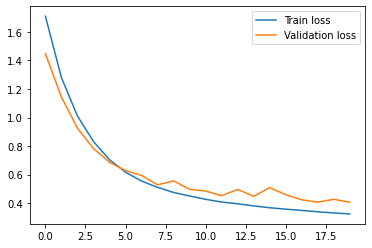

In [ ]:
plot(loss_arr, loss_arr_test)

In [ ]:
print("Loss: ", loss_arr_test[-1])

Loss:  0.4062493219971657


* Посмотрите на качество получившейся модели. Вернитесь по коду вверх и раскоментируйте строки, где картинки нормируются к отрезку $[0;1]$. Переобучите сетку. Что произошло с качеством? 
* Теперь попробуйте использовать в качестве функции активации линейную функцию. Что произошло с качеством модели?  

Можно посмотреть, где именно сетка ошибается. 

In [ ]:
_, y_pred = eval_nn(testloader, model_fc, loss_fn, device)
X_test = testset.data.numpy()
y_test = testset.targets.numpy()

errors =  y_pred != y_test

# срежем только наблюдения, где была ошибка вместе с метками
X_err = X_test[errors]
y_err = y_test[errors]
y_pred = y_pred[errors]

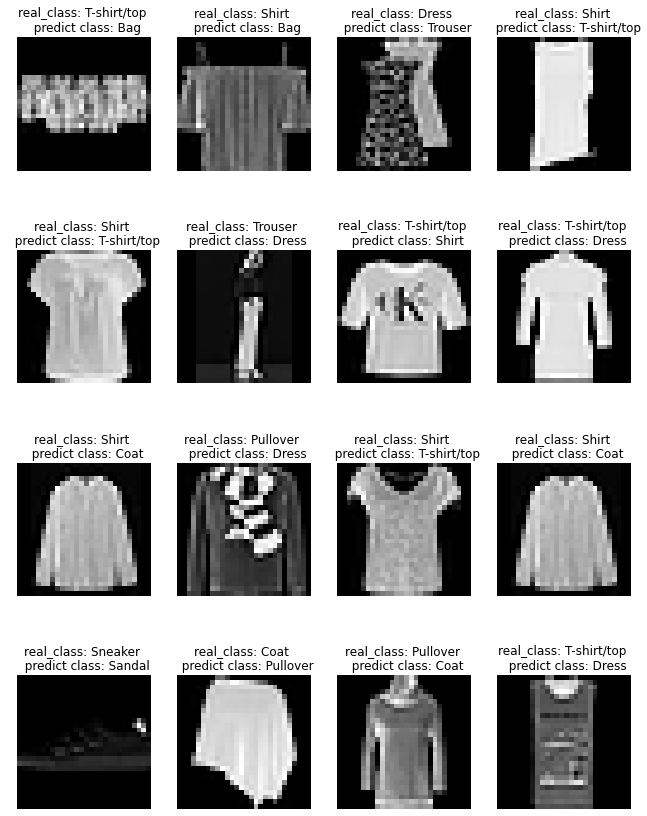

In [ ]:
cols = 4
rows = 4
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(class_names[y_err[random_index]], 
                                                                   class_names[y_pred[random_index]]))
plt.show()

## 2.2 Свёрточная сетка 

Теперь давайте соберём свёртоную сеть: 

* Свёртка с ядром $5 \times 5$ и $6$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям
* Свёртка с ядром $5 \times 5$ и $16$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям 
* Свёртка с ядром $4 \times 4$ и $120$ каналами
* Дальше сделайте `Flatten` и сделайте два полносвязных слоя с ReLU и $120$ и $84$ нейронами

Хорошая [статья](https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320) о том, как писать такую сетку на PyTorch

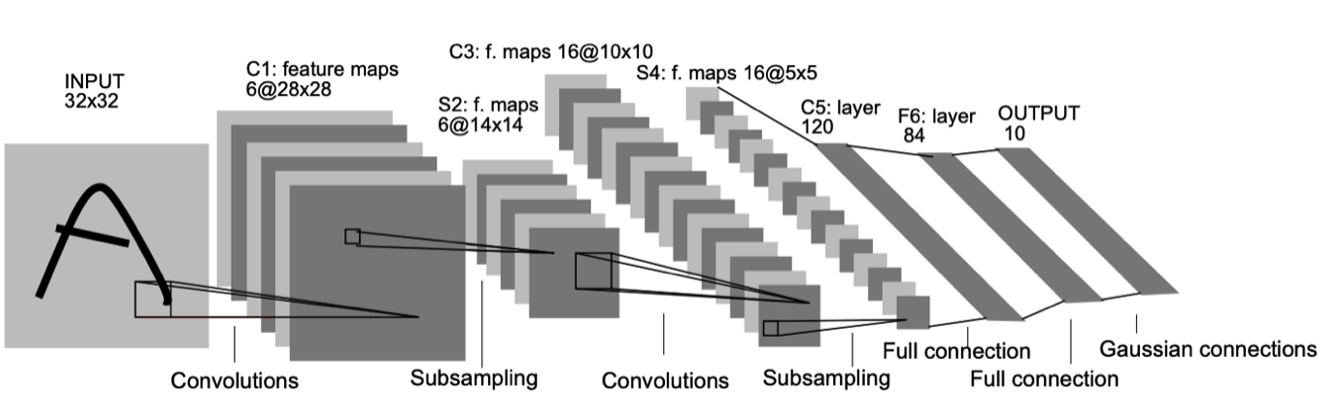

In [ ]:
display.Image('images/lenet.png', retina=True)

Также стоит держать в голове формулы для рассчета размера выхода после \
**Convolutional и Max/Avg pooling слоев:**
$$\dfrac{W−F+2P}{S}+1$$

- W is the input height/width (normally the images are squares, so there is no need to differentiate the two)
- F is the filter/kernel size
- P is the padding
- S is the stride

In [ ]:
# 
#  Ваша LeNet сетка :) 
#  

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_cnn = CNN()
model_cnn.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model_cnn.parameters(), lr=0.01)

loss_arr, loss_arr_test = training_loop(model_cnn, trainloader, testloader, opt, loss_fn, device, max_epochs=20)

cuda
EPOCH 0 : train_loss: 2.28634 test_loss: 2.27032
EPOCH 4 : train_loss: 1.45008 test_loss: 1.35494
EPOCH 8 : train_loss: 1.09889 test_loss: 1.08515
EPOCH 12 : train_loss: 0.95062 test_loss: 0.94462
EPOCH 16 : train_loss: 0.82073 test_loss: 0.82530


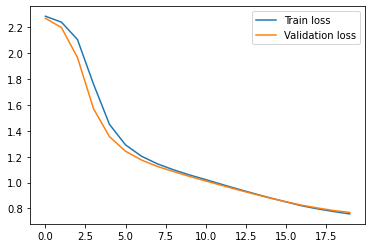

In [ ]:
plot(loss_arr, loss_arr_test)

In [ ]:
print("Loss: ", loss_arr_test[-1])

Loss:  0.7689385384321212


Точность должна была довольно сильно подскочить, но пока этого не произошло. \

**Домашнее задание:** 
1. добавить в pipeline расчет точности в дополнение к loss
2. улучшить качество обеих моделей (FC и CNN). В особенности CNN. Возможно, стоит изменить кол-во эпох, LR, optimizer...
3.\* Обернуть модель, функции обучения, валидации и рисования в класс. Тут нет четких критериев того, как это делать. Любые решения принимаются. Это важно для понимания того как работают классы. Можно начать с того, что поискать в интернете как обычно реализуются такие структуры.

In [ ]:
X_test.shape

In [ ]:
np.squeeze(X_test, axis=3).shape

In [ ]:
y_pred = model_2.predict_classes(X_test)
errors =  y_pred != y_test

X_err = np.squeeze(X_test[errors], axis=3)
y_err = y_test[errors]
y_pred = y_pred[errors]

In [ ]:
cols = 4
rows = 4
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(class_names[y_err[random_index]], 
                                                                   class_names[y_pred[random_index]]))
plt.show()

Вот так, кстати говоря, выглядят ошибки аналогичной неронки на MNIST. Кстати говоря, чтобы посмотреть как именно код работает на этом датасете, достаточно просто поменять первые строки с подгрузкой данных в тетрадку. 


![ ](https://raw.githubusercontent.com/FUlyankin/neural_nets_econ/master/2019/sem_6_pic/MNIST_error.png)